In [ ]:
import json
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
from typing_extensions import TypedDict
from IPython.display import Image, display

def load_json_data(file_path: str):
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)


@tool
def fetch_store_data(store_id: int) -> str:
    """IDを指定して店舗データを取得します。"""
    data = load_json_data("/content/sample_data/store_data.json")
    filtered_data = [store for store in data if store["id"] == store_id]
    return json.dumps(filtered_data, ensure_ascii=False, indent=2)


@tool
def fetch_reviews(store_id: int) -> str:
    """指定された店舗IDの口コミを取得します。"""
    data = load_json_data("/content/sample_data/reviews.json")
    filtered_data = [review for review in data if review["store_id"] == store_id]
    return json.dumps(filtered_data, ensure_ascii=False, indent=2)


@tool
def fetch_ratings() -> str:
    """
    全店舗の評価を取得します。
    """
    data = load_json_data("/content/sample_data/ratings.json")
    return json.dumps(data, ensure_ascii=False, indent=2)


tools = [fetch_store_data, fetch_reviews, fetch_ratings]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # assert len(message.tool_calls) > 0, "No tool call"
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Exception:", e)

# 検証1: 引数が多い関数が適切に呼び出せるか

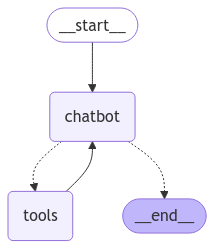

In [28]:
import json
from typing import Annotated, Literal, List, Optional
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
from typing_extensions import TypedDict
from IPython.display import Image, display
from datetime import datetime, timedelta
import random


@tool
def fetch_reviews(
    store_id: int,
    query: str,
    posted_at_from: datetime,
    posted_at_to: datetime,
    limit: int,
    sentiment: Literal["positive", "negative"],
    categories: Optional[List[str]] = [],
) -> List[dict]:
    """
    Fetch reviews from the JSON file based on the provided arguments.

    Args:
        store_id (int): The store ID.
        query (str): The search query.
        posted_at_from (datetime): The start of the date range.
        posted_at_to (datetime): The end of the date range.
        categories (list, optional): List of categories to filter by. Defaults to None.
        limit (int): Maximum number of reviews to fetch.
        sentiment (Literal['positive', 'negative']): Filter reviews by sentiment.

    Returns:
        list: A list of filtered review objects.
    """

    mock_reviews = []
    if not categories:
        categories = ["味", "雰囲気", "接客"]

    for i in range(limit):
        review_categories = random.sample(categories, k=min(len(categories), random.randint(1, 3)))
        review = {
            "store_id": store_id,
            "id": i + 1,
            "content": f"Mock review content for query '{query}' and category '{random.choice(categories)}'",
            "sentiment": sentiment,
            "categories": review_categories,
            "posted_at": (
                posted_at_from
                + timedelta(
                    days=random.randint(0, (posted_at_to - posted_at_from).days)
                )
            ).isoformat(),
        }
        mock_reviews.append(review)

    return mock_reviews


tools = [fetch_reviews]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)


class State(TypedDict):
    messages: Annotated[List, add_messages]


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # assert len(message.tool_calls) > 0, "No tool call"
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Exception:", e)


In [29]:
user_input = """
以下の条件で口コミを収集して、店舗改善案を提案してください。今日は2025/01/23です。
- 直近1年の口コミ
- 店舗ID=5
- 好意的な口コミ
- 味に関する口コミ
- 上位10件
"""
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================


以下の条件で口コミを収集して、店舗改善案を提案してください。今日は2025/01/23です。
- 直近1年の口コミ
- 店舗ID=5
- 好意的な口コミ
- 味に関する口コミ
- 上位10件

================================== Ai Message ==================================
Tool Calls:
  fetch_reviews (call_fW7iKiJ4snDA6GfNiREGdsIg)
 Call ID: call_fW7iKiJ4snDA6GfNiREGdsIg
  Args:
    store_id: 5
    query: 味
    posted_at_from: 2024-01-23T00:00:00
    posted_at_to: 2025-01-23T00:00:00
    limit: 10
    sentiment: positive
================================= Tool Message =================================
Name: fetch_reviews

[{"store_id": 5, "id": 1, "content": "Mock review content for query '味' and category '接客'", "sentiment": "positive", "categories": ["雰囲気", "接客", "味"], "posted_at": "2024-06-15T00:00:00"}, {"store_id": 5, "id": 2, "content": "Mock review content for query '味' and category '雰囲気'", "sentiment": "positive", "categories": ["雰囲気", "味", "接客"], "posted_at": "2024-08-25T00:00:00"}, {"store_

# 検証2: 検索条件を他の関数の実行結果から生成できるか

指示: 評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください

- 店舗評価から最も評価の高い店舗を抽出し、store_idを取得できる
- 売り上げ推移から、売り上げが好調だった時期を抽出し、口コミの絞り込み条件に反映できる
- 料理に関する口コミを収集する際、カテゴリでは絞り込まず、「料理」とキーワード検索してしまう

指示2: 評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください。
口コミを収集する際は、料理に関する口コミカテゴリが存在するかを確認し、適切なカテゴリに絞って検索してください。

- 「品質」カテゴリ「料理」キーワードの口コミを収集するようになった

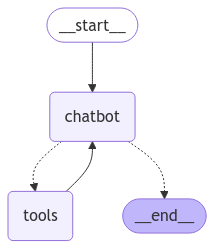

In [39]:
from typing import Dict

@tool
def fetch_reviews(
    store_id: int,
    query: str,
    posted_at_from: datetime,
    posted_at_to: datetime,
    limit: int,
    sentiment: Literal["positive", "negative"],
    categories: Optional[List[str]] = [],
) -> List[dict]:
    """
    Fetch reviews from the JSON file based on the provided arguments.

    Args:
        store_id (int): The store ID.
        query (str): The search query.
        posted_at_from (datetime): The start of the date range.
        posted_at_to (datetime): The end of the date range.
        categories (list, optional): List of categories to filter by. Defaults to None.
        limit (int): Maximum number of reviews to fetch.
        sentiment (Literal['positive', 'negative']): Filter reviews by sentiment.

    Returns:
        list: A list of filtered review objects.
    """

    mock_reviews = []
    if not categories:
        categories = ["雰囲気", "接客"]

    for i in range(limit):
        review_categories = random.sample(categories, k=min(len(categories), random.randint(1, 3)))
        review = {
            "store_id": store_id,
            "id": i + 1,
            "content": f"Mock review content for query '{query}' and category '{random.choice(categories)}'",
            "sentiment": sentiment,
            "categories": review_categories,
            "posted_at": (
                posted_at_from
                + timedelta(
                    days=random.randint(0, (posted_at_to - posted_at_from).days)
                )
            ).isoformat(),
        }
        mock_reviews.append(review)

    return mock_reviews

@tool
def fetch_categories() -> List[str]:
    """
    Fetch a list of predefined categories.

    Returns:
        list: A list of category strings.
    """
    return ["価格", "雰囲気", "接客", "品質"]

@tool
def fetch_store_ratings() -> Dict[int, float]:
    """
    Fetch store ratings for all stores.

    Returns:
        dict: A dictionary where keys are store IDs and values are ratings (1.0 to 5.0).
    """
    return {
        1: 1.3,
        2: 4.0,
        3: 1.0,
        4: 3.5,
        5: 3.6,
        6: 3.9,
        7: 3.5,
        8: 4.9,
        9: 3.4,
        10: 2.0,
    }

@tool
def fetch_sales_trends(store_id: int) -> Dict[str, int]:
    """
    Fetch monthly sales trends for a specific store.

    Args:
        store_id (int): The store ID.

    Returns:
        dict: A dictionary where keys are months and values are sales numbers.
    """
    sales_trends = {}
    for month in range(1, 13):
        if month in [7, 8]:
            sales = random.randint(2000, 3000)  # 7~8月の売り上げが高い
        else:
            sales = random.randint(500, 1500)
        sales_trends[f"2024-{month:02d}"] = sales
    sales_trends["2025-01"] = random.randint(500, 1500)
    return sales_trends

tools = [fetch_reviews, fetch_categories, fetch_store_ratings, fetch_sales_trends]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[List, add_messages]


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # assert len(message.tool_calls) > 0, "No tool call"
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Exception:", e)

In [40]:
user_input = "評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください"
config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください
================================== Ai Message ==================================
Tool Calls:
  fetch_store_ratings (call_EARtfFjeYN2xkk3NwxHTZpBc)
 Call ID: call_EARtfFjeYN2xkk3NwxHTZpBc
  Args:
================================= Tool Message =================================
Name: fetch_store_ratings

{"1": 1.3, "2": 4.0, "3": 1.0, "4": 3.5, "5": 3.6, "6": 3.9, "7": 3.5, "8": 4.9, "9": 3.4, "10": 2.0}
================================== Ai Message ==================================
Tool Calls:
  fetch_sales_trends (call_RTzc4xpfySsTL45tQ5bdmY9I)
 Call ID: call_RTzc4xpfySsTL45tQ5bdmY9I
  Args:
    store_id: 8
================================= Tool Message =================================
Name: fetch_sales_trends

{"2024-01": 1033, "2024-02": 623, "2024-03": 1253, "2024-04": 520, "2024-05": 933, "2024-06": 1414, "2024-07": 2543, "2024-08": 2657, "

In [42]:
user_input = """
評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください。
口コミを収集する際は、料理に関する口コミカテゴリが存在するかを確認し、適切なカテゴリに絞って検索してください。
"""
config = {"configurable": {"thread_id": "3"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================


評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください。
口コミを収集する際は、料理に関する口コミカテゴリが存在するかを確認し、適切なカテゴリに絞って検索してください。

================================== Ai Message ==================================
Tool Calls:
  fetch_store_ratings (call_nrAClOdZoUdM8RGBYO4NFaHq)
 Call ID: call_nrAClOdZoUdM8RGBYO4NFaHq
  Args:
================================= Tool Message =================================
Name: fetch_store_ratings

{"1": 1.3, "2": 4.0, "3": 1.0, "4": 3.5, "5": 3.6, "6": 3.9, "7": 3.5, "8": 4.9, "9": 3.4, "10": 2.0}
================================== Ai Message ==================================
Tool Calls:
  fetch_sales_trends (call_BuLhFv2wrQqiU2EX3Ygj7JEq)
 Call ID: call_BuLhFv2wrQqiU2EX3Ygj7JEq
  Args:
    store_id: 8
================================= Tool Message =================================
Name: fetch_sales_trends

{"2024-01": 972, "2024-02": 1274, "2024-03": 1073, "2024-04": 806, "2024-05"